# Benchmark

In [1]:
from scipy import stats
from sklearn import metrics
import pandas as pd
import numpy as np
import pickle
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def print_absolute_and_percent(pct,total):
    absolute = round((pct*total/100))
    return "{:.1f}%\n({:d})".format(pct,absolute)

HLA-B    56
HLA-A    38
HLA-C    21
Name: hla_class, dtype: int64

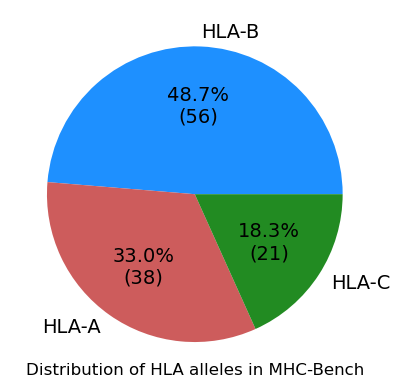

In [42]:
# HLA distribution
mhc_bench_df = pd.read_csv('./data/MHC-Bench/MHC-Bench.csv',index_col=0)

hla_df = pd.DataFrame({'hla_class':[i[:5] for i in set(mhc_bench_df['mhc'])]})
                        
x = hla_df['hla_class'].value_counts().reset_index()['hla_class']
plt.pie(x=x,
       labels=['HLA-B','HLA-A','HLA-C'], autopct=lambda pct: print_absolute_and_percent(pct,np.sum(x)),
        colors=['DodgerBlue','IndianRed','ForestGreen'],textprops={'fontsize': 14})
plt.title('Distribution of HLA alleles in MHC-Bench', y=-0.01)

hla_df['hla_class'].value_counts()

overall positive class %:  3.532434780123516


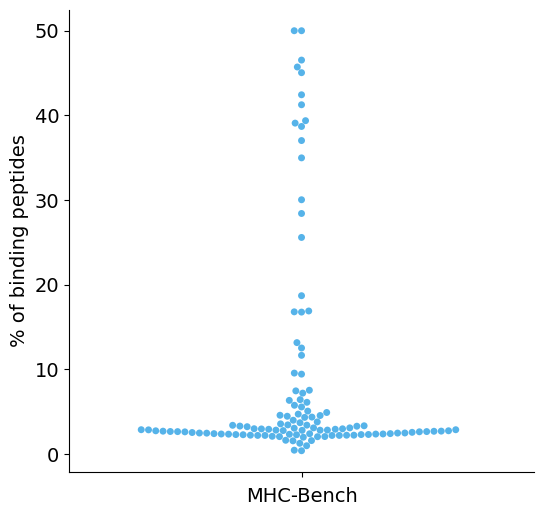

In [51]:
# Positive negative split
percent_ls = mhc_bench_df[['mhc','binding']].groupby('mhc').sum()*100/mhc_bench_df[['mhc','binding']].groupby('mhc').count()
percent_ls = percent_ls['binding'].to_list()


fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(6,6))

b = sns.swarmplot(data=pd.DataFrame({'Positive Percent':percent_ls}),
            y = 'Positive Percent', ax=axs, color='#56b3e9')

b.set_ylabel('% of binding peptides',fontsize=14)
b.set_xlabel('MHC-Bench',fontsize=14)
plt.yticks(fontsize=14)
sns.despine(right=True,top=True)

print("overall positive class %: ",mhc_bench_df['binding'].sum()*100/len(mhc_bench_df['binding']))
plt.savefig('./figures/percent_binding.svg',bbox_inches="tight",dpi=300)

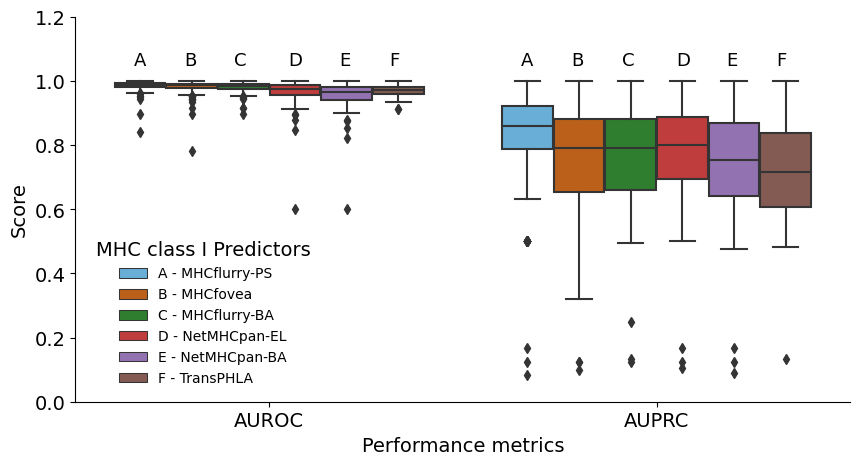

In [41]:
# Plot MHC-Bench AUROC and AUPR scores
with open('./data/benchmark/mhcflurry_bench_metrics.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
x =  mhcflurry_bench_metrics['ROC_ps'] + mhcfovea_bench_metrics['ROC'] + mhcflurry_bench_metrics['ROC_BA'] + \
         netmhcpan_bench_metrics['ROC_EL']  + netmhcpan_bench_metrics['ROC_BA'] + transphla_bench_metrics['ROC']
    
len_  = len(mhcflurry_bench_metrics['ROC_ps'])

y = ['A - MHCflurry-PS']*len_+ ['B - MHCfovea']*len_ + ['C - MHCflurry-BA']*len_ + \
    ['D - NetMHCpan-EL']*len_ + ['E - NetMHCpan-BA']*len_ + ['F - TransPHLA']*len_

roc_df = pd.DataFrame({'x' : x,
                       'predictor' : y})
roc_df['y'] = ['ROC AUC']*len(roc_df)

x = mhcflurry_bench_metrics['PR_ps'] + mhcfovea_bench_metrics['PR'] + mhcflurry_bench_metrics['PR_BA'] + \
         netmhcpan_bench_metrics['PR_EL']  + netmhcpan_bench_metrics['PR_BA'] + transphla_bench_metrics['PR']

len_  = len(mhcflurry_bench_metrics['PR_ps'])

y = ['A - MHCflurry-PS']*len_ + ['B - MHCfovea']*len_ + ['C - MHCflurry-BA']*len_ + \
    ['D - NetMHCpan-EL']*len_ + ['E - NetMHCpan-BA']*len_ + ['F - TransPHLA']*len_


PR_df = pd.DataFrame({'x' : x,
                       'predictor' : y})
PR_df['y'] = ['Precision-Recall AUC']*len(PR_df)


df = pd.concat([roc_df,PR_df])

palette = ['#56b3e9','#d55c00','ForestGreen','#d62728','#9467bd','#8c564b']

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,5))

b = sns.boxplot(data=df, x='y', y='x',ax=axs, hue="predictor", palette=palette)

plt.text(-0.35,1.05,'A', fontsize=13)
plt.text(-0.22,1.05,'B', fontsize=13)
plt.text(-0.09,1.05,'C', fontsize=13)
plt.text(0.05,1.05,'D', fontsize=13)
plt.text(0.18,1.05,'E', fontsize=13)
plt.text(0.31,1.05,'F', fontsize=13)

plt.text(1-0.35,1.05,'A', fontsize=13)
plt.text(1-0.22,1.05,'B', fontsize=13)
plt.text(1-0.09,1.05,'C', fontsize=13)
plt.text(1+0.05,1.05,'D', fontsize=13)
plt.text(1+0.18,1.05,'E', fontsize=13)
plt.text(1+0.31,1.05,'F', fontsize=13)

# plt.text(3.5,8,'D - NetMHCpan-EL \nE - NetMHCpan-BA \nF - TransPHLA', fontsize=13)
axs.set_ylim(0,1.2)

b.set_xticklabels(['AUROC','AUPRC'],size=14,rotation=0)
b.set_ylabel('Score',fontsize=14)
plt.yticks(fontsize=14)
b.set_xlabel('Performance metrics',fontsize=14)
sns.despine(top=True,right=True)

plt.legend(title='MHC class I Predictors', loc="lower left", title_fontsize=14,
           frameon=False, bbox_to_anchor=(0.01,0.01))

plt.savefig('./figures/benchmark_1.svg',bbox_inches="tight",dpi=300)

In [32]:
# Statistical Significance
# For AUROC

x = [[None] for i in range(6)]
x[0] = mhcflurry_bench_metrics['ROC_ps']
x[1] = mhcfovea_bench_metrics['ROC']
x[2] = mhcflurry_bench_metrics['ROC_BA']
x[3] = netmhcpan_bench_metrics['ROC_EL']
x[4] = netmhcpan_bench_metrics['ROC_BA']
x[5] = transphla_bench_metrics['ROC']

print(stats.kruskal(x[0], x[1], x[2], x[3], x[4], x[5]))
print(np.array(x).mean(axis=1))

# For AUPRC

x = [[None] for i in range(6)]
x[0] = mhcflurry_bench_metrics['PR_ps']
x[1] = mhcfovea_bench_metrics['PR']
x[2] = mhcflurry_bench_metrics['PR_BA']
x[3] = netmhcpan_bench_metrics['PR_EL']
x[4] = netmhcpan_bench_metrics['PR_BA']
x[5] = transphla_bench_metrics['PR']

print(stats.kruskal(x[0], x[1], x[2], x[3], x[4], x[5]))
print(np.array(x).mean(axis=1))


KruskalResult(statistic=124.98442321907399, pvalue=2.7571602566449864e-25)
[0.98327898 0.9791856  0.98026542 0.96422014 0.95466674 0.96974698]
KruskalResult(statistic=56.03577042935643, pvalue=7.989889304818218e-11)
[0.85778417 0.79485246 0.79369646 0.8057726  0.76623785 0.75214592]


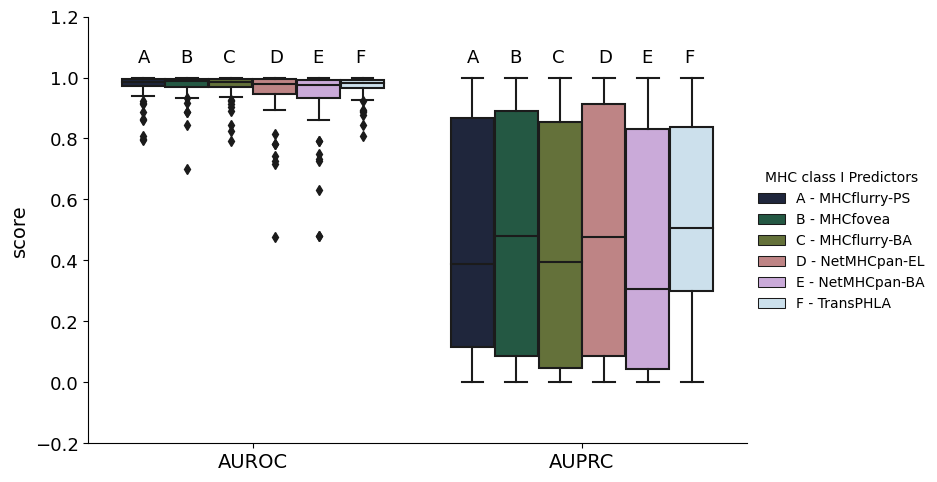

In [5]:
# Plot MHC-Bench-v2 AUROC and AUPR scores
import math

with open('./data/benchmark/mhcflurry_bench_metrics_v2.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_v2.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_v2.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics_v2.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
x =  mhcflurry_bench_metrics['ROC_ps'] + mhcfovea_bench_metrics['ROC'] + mhcflurry_bench_metrics['ROC_BA'] + \
         netmhcpan_bench_metrics['ROC_EL']  + netmhcpan_bench_metrics['ROC_BA'] + transphla_bench_metrics['ROC']
    
y = ['A - MHCflurry-PS']*79 + ['B - MHCfovea']*79 + ['C - MHCflurry-BA']*79 + \
    ['D - NetMHCpan-EL']*79 + ['E - NetMHCpan-BA']*79 + ['F - TransPHLA']*79

roc_df = pd.DataFrame({'x' : x,
                       'predictor' : y})



x = mhcflurry_bench_metrics['PR_ps'] +\
    mhcfovea_bench_metrics['PR'] + \
    mhcflurry_bench_metrics['PR_BA']+ \
    netmhcpan_bench_metrics['PR_EL'] +\
    netmhcpan_bench_metrics['PR_BA'] +\
    transphla_bench_metrics['PR']
    
y = ['A - MHCflurry-PS']*79 + ['B - MHCfovea']*79 + ['C - MHCflurry-BA']*79 + \
    ['D - NetMHCpan-EL']*79 + ['E - NetMHCpan-BA']*79 + ['F - TransPHLA']*79


PR_df = pd.DataFrame({'x' : x,
                       'predictor' : y})


roc_df['y'] = ['ROC AUC']*len(roc_df)

PR_df['y'] = ['Precision-Recall AUC']*len(PR_df)
# MCC_df['y'] = ['MCC']*len(MCC_df)

df = pd.concat([roc_df,PR_df])

b = sns.catplot(data=df, x='y', y='x',kind='box',hue="predictor", palette='cubehelix', height=5, aspect=1.5)

plt.text(-0.35,1.05,'A', fontsize=13)
plt.text(-0.22,1.05,'B', fontsize=13)
plt.text(-0.09,1.05,'C', fontsize=13)
plt.text(0.05,1.05,'D', fontsize=13)
plt.text(0.18,1.05,'E', fontsize=13)
plt.text(0.31,1.05,'F', fontsize=13)

plt.text(1-0.35,1.05,'A', fontsize=13)
plt.text(1-0.22,1.05,'B', fontsize=13)
plt.text(1-0.09,1.05,'C', fontsize=13)
plt.text(1+0.05,1.05,'D', fontsize=13)
plt.text(1+0.18,1.05,'E', fontsize=13)
plt.text(1+0.31,1.05,'F', fontsize=13)

# plt.text(3.5,8,'D - NetMHCpan-EL \nE - NetMHCpan-BA \nF - TransPHLA', fontsize=13)

b.set_xticklabels(['AUROC','AUPRC'],size=14,rotation=0)
b.set_ylabels('score',size=14)
b.set_xlabels('')
b.legend.set_title('MHC class I Predictors')
b.set_yticklabels(size=13)
# b.savefig('./SVGs/benchmark_.svg',bbox_inches="tight")

In [32]:
# Statistical Significance
# For AUROC
x = [[None] for i in range(6)]
x[0] = mhcflurry_bench_metrics['ROC_ps']
x[1] = mhcfovea_bench_metrics['ROC']
x[2] = mhcflurry_bench_metrics['ROC_BA']
x[3] = netmhcpan_bench_metrics['ROC_EL']
x[4] = netmhcpan_bench_metrics['ROC_BA']
x[5] = transphla_bench_metrics['ROC']

print(stats.kruskal(x[0], x[1], x[2], x[3], x[4], x[5]))

print(np.array(x).mean(axis=1))

# For AUPRC

x = [[None] for i in range(6)]
x[0] = mhcflurry_bench_metrics['PR_ps']
x[1] = mhcfovea_bench_metrics['PR']
x[2] = mhcflurry_bench_metrics['PR_BA']
x[3] = netmhcpan_bench_metrics['PR_EL']
x[4] = netmhcpan_bench_metrics['PR_BA']
x[5] = transphla_bench_metrics['PR']

print(stats.kruskal(x[0], x[1], x[2], x[3], x[4], x[5]))
print(np.array(x).mean(axis=1))


KruskalResult(statistic=11.770077937832967, pvalue=0.03807773914081961)
[0.96989813 0.97431466 0.97179737 0.95240621 0.93603206 0.9693117 ]
KruskalResult(statistic=4.6724144801016285, pvalue=0.4571513919573871)
[0.47370474 0.47749343 0.45319248 0.49516607 0.44256036 0.54808785]


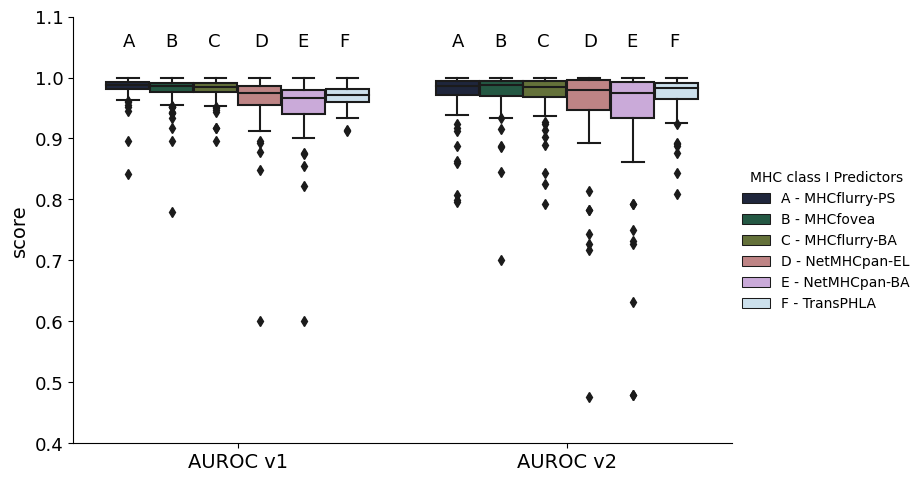

In [7]:
### AUROC

# v1
import math

with open('./data/benchmark/mhcflurry_bench_metrics.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
nan_pos = [i for i in range(len(mhcflurry_bench_metrics['SRCC_BA'])) if math.isnan(mhcflurry_bench_metrics['SRCC_BA'][i])]

x =  mhcflurry_bench_metrics['ROC_ps'] + mhcfovea_bench_metrics['ROC'] + mhcflurry_bench_metrics['ROC_BA'] + \
         netmhcpan_bench_metrics['ROC_EL']  + netmhcpan_bench_metrics['ROC_BA'] + transphla_bench_metrics['ROC']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + ['C - MHCflurry-BA']*115 + \
    ['D - NetMHCpan-EL']*115 + ['E - NetMHCpan-BA']*115 + ['F - TransPHLA']*115

roc_v1_df = pd.DataFrame({'x' : x,
                          'predictor' : y,
                          'y' : ['ROC AUC v1']*len(y)})


# v2
with open('./data/benchmark/mhcflurry_bench_metrics_v2.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_v2.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_v2.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics_v2.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
x =  mhcflurry_bench_metrics['ROC_ps'] + mhcfovea_bench_metrics['ROC'] + mhcflurry_bench_metrics['ROC_BA'] + \
         netmhcpan_bench_metrics['ROC_EL']  + netmhcpan_bench_metrics['ROC_BA'] + transphla_bench_metrics['ROC']
    
y = ['A - MHCflurry-PS']*79 + ['B - MHCfovea']*79 + ['C - MHCflurry-BA']*79 + \
    ['D - NetMHCpan-EL']*79 + ['E - NetMHCpan-BA']*79 + ['F - TransPHLA']*79

roc_v2_df = pd.DataFrame({'x' : x,
                          'predictor' : y,
                          'y' : ['ROC AUC v2']*len(y)})

df = pd.concat([roc_v1_df,roc_v2_df])

b = sns.catplot(data=df, x='y', y='x',kind='box',hue="predictor", palette='cubehelix', height=5, aspect=1.5)

plt.text(-0.35,1.05,'A', fontsize=13)
plt.text(-0.22,1.05,'B', fontsize=13)
plt.text(-0.09,1.05,'C', fontsize=13)
plt.text(0.05,1.05,'D', fontsize=13)
plt.text(0.18,1.05,'E', fontsize=13)
plt.text(0.31,1.05,'F', fontsize=13)

plt.text(1-0.35,1.05,'A', fontsize=13)
plt.text(1-0.22,1.05,'B', fontsize=13)
plt.text(1-0.09,1.05,'C', fontsize=13)
plt.text(1+0.05,1.05,'D', fontsize=13)
plt.text(1+0.18,1.05,'E', fontsize=13)
plt.text(1+0.31,1.05,'F', fontsize=13)

b.set_xticklabels(['AUROC v1','AUROC v2'],size=14,rotation=0)
b.set_ylabels('score',size=14)
b.set_xlabels('')
b.legend.set_title('MHC class I Predictors')
b.set_yticklabels(size=13)





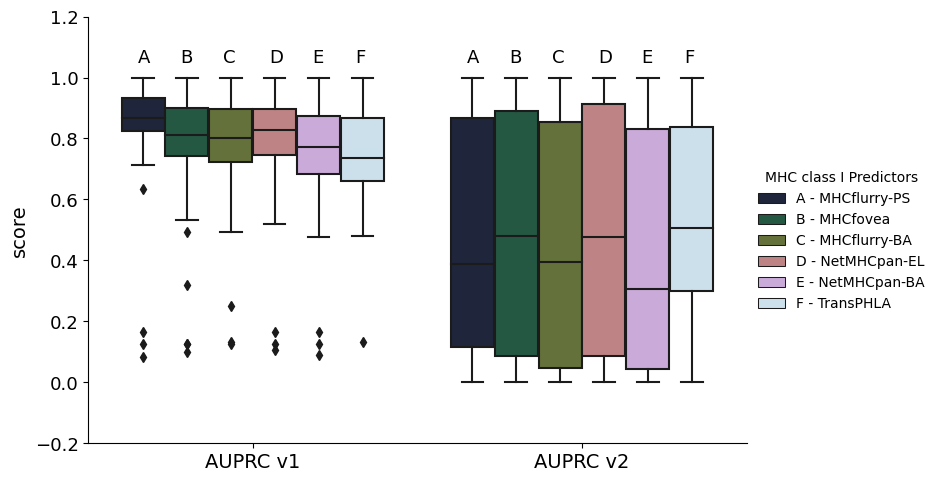

In [13]:
### AUPRC

# v1
import math

with open('./data/benchmark/mhcflurry_bench_metrics.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
nan_pos = [i for i in range(len(mhcflurry_bench_metrics['SRCC_BA'])) if math.isnan(mhcflurry_bench_metrics['SRCC_BA'][i])]

# x =  mhcflurry_bench_metrics['PR_ps'] + mhcfovea_bench_metrics['PR'] + mhcflurry_bench_metrics['PR_BA'] + \
#          netmhcpan_bench_metrics['PR_EL']  + netmhcpan_bench_metrics['PR_BA'] + transphla_bench_metrics['PR']

len_ = len(mhcfovea_bench_metrics['PR'])
x = [mhcflurry_bench_metrics['PR_ps'][i] for i in range(len_) if i not in nan_pos] +\
    [mhcfovea_bench_metrics['PR'][i] for i in range(len_) if i not in nan_pos] + \
    [mhcflurry_bench_metrics['PR_BA'][i] for i in range(len_) if i not in nan_pos]+ \
    [netmhcpan_bench_metrics['PR_EL'][i] for i in range(len_) if i not in nan_pos]  +\
    [netmhcpan_bench_metrics['PR_BA'][i] for i in range(len_) if i not in nan_pos] +\
    [transphla_bench_metrics['PR'][i] for i in range(len_) if i not in nan_pos]

y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + ['C - MHCflurry-BA']*115 + \
    ['D - NetMHCpan-EL']*115 + ['E - NetMHCpan-BA']*115 + ['F - TransPHLA']*115

PR_v1_df = pd.DataFrame({'x' : x,
                          'predictor' : y,
                          'y' : ['PR AUC v1']*len(y)})


# v2
with open('./data/benchmark/mhcflurry_bench_metrics_v2.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_v2.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_v2.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics_v2.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
x =  mhcflurry_bench_metrics['PR_ps'] + mhcfovea_bench_metrics['PR'] + mhcflurry_bench_metrics['PR_BA'] + \
         netmhcpan_bench_metrics['PR_EL']  + netmhcpan_bench_metrics['PR_BA'] + transphla_bench_metrics['PR']

    
y = ['A - MHCflurry-PS']*79 + ['B - MHCfovea']*79 + ['C - MHCflurry-BA']*79 + \
    ['D - NetMHCpan-EL']*79 + ['E - NetMHCpan-BA']*79 + ['F - TransPHLA']*79

PR_v2_df = pd.DataFrame({'x' : x,
                          'predictor' : y,
                          'y' : ['PR AUC v2']*len(y)})

df = pd.concat([PR_v1_df,PR_v2_df])

b = sns.catplot(data=df, x='y', y='x',kind='box',hue="predictor", palette='cubehelix', height=5, aspect=1.5)

plt.text(-0.35,1.05,'A', fontsize=13)
plt.text(-0.22,1.05,'B', fontsize=13)
plt.text(-0.09,1.05,'C', fontsize=13)
plt.text(0.05,1.05,'D', fontsize=13)
plt.text(0.18,1.05,'E', fontsize=13)
plt.text(0.31,1.05,'F', fontsize=13)

plt.text(1-0.35,1.05,'A', fontsize=13)
plt.text(1-0.22,1.05,'B', fontsize=13)
plt.text(1-0.09,1.05,'C', fontsize=13)
plt.text(1+0.05,1.05,'D', fontsize=13)
plt.text(1+0.18,1.05,'E', fontsize=13)
plt.text(1+0.31,1.05,'F', fontsize=13)

b.set_xticklabels(['AUPRC v1','AUPRC v2'],size=14,rotation=0)
b.set_ylabels('score',size=14)
b.set_xlabels('')
b.legend.set_title('MHC class I Predictors')
b.set_yticklabels(size=13)


In [14]:
# Print averages of AUROC and AUPRC, and their ranking
with open('./data/benchmark/mhcflurry_bench_metrics.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
nan_pos = [i for i in range(len(mhcflurry_bench_metrics['SRCC_BA'])) if math.isnan(mhcflurry_bench_metrics['SRCC_BA'][i])]

len_ = len(mhcfovea_bench_metrics['ROC'])
x = [mhcflurry_bench_metrics['ROC_ps'],
     mhcfovea_bench_metrics['ROC'],
     mhcflurry_bench_metrics['ROC_BA'],
     netmhcpan_bench_metrics['ROC_EL'],
     netmhcpan_bench_metrics['ROC_BA'],
     transphla_bench_metrics['ROC']]

df = pd.DataFrame(x).T.rename(columns={0:'MHCflurry-PS', 
                                  1:'MHCfovea', 
                                  2:'MHCflurry-BA', 
                                  3:'NetMHCpan-EL', 
                                  4:'NetMHCpan-BA', 
                                  5:'TransPHLA'})

print("ranking by AUROC 115 v1: ",df.mean().sort_values(ascending=False).index.to_list())
print(df.mean())

# v2
with open('./data/benchmark/mhcflurry_bench_metrics_v2.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_v2.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_v2.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics_v2.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)

x =  [mhcflurry_bench_metrics['ROC_ps'], mhcfovea_bench_metrics['ROC'], mhcflurry_bench_metrics['ROC_BA'],
         netmhcpan_bench_metrics['ROC_EL'], netmhcpan_bench_metrics['ROC_BA'], transphla_bench_metrics['ROC']]
df = pd.DataFrame(x).T.rename(columns={0:'MHCflurry-PS', 
                                  1:'MHCfovea', 
                                  2:'MHCflurry-BA', 
                                  3:'NetMHCpan-EL', 
                                  4:'NetMHCpan-BA', 
                                  5:'TransPHLA'})

print("ranking by AUROC 79 v2: ",df.mean().sort_values(ascending=False).index.to_list())
print(df.mean())



print("\n --------------> AUPR \n")

with open('./data/benchmark/mhcflurry_bench_metrics.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)
    
nan_pos = [i for i in range(len(mhcflurry_bench_metrics['SRCC_BA'])) if math.isnan(mhcflurry_bench_metrics['SRCC_BA'][i])]

len_ = len(mhcfovea_bench_metrics['PR'])
x = [[mhcflurry_bench_metrics['PR_ps'][i] for i in range(len_) if i not in nan_pos],
    [mhcfovea_bench_metrics['PR'][i] for i in range(len_) if i not in nan_pos],
    [mhcflurry_bench_metrics['PR_BA'][i] for i in range(len_) if i not in nan_pos],
    [netmhcpan_bench_metrics['PR_EL'][i] for i in range(len_) if i not in nan_pos],
    [netmhcpan_bench_metrics['PR_BA'][i] for i in range(len_) if i not in nan_pos],
    [transphla_bench_metrics['PR'][i] for i in range(len_) if i not in nan_pos]]

df = pd.DataFrame(x).T.rename(columns={0:'MHCflurry-PS', 
                                  1:'MHCfovea', 
                                  2:'MHCflurry-BA', 
                                  3:'NetMHCpan-EL', 
                                  4:'NetMHCpan-BA', 
                                  5:'TransPHLA'})

print("ranking by AUPRC 115 v1: ",df.mean().sort_values(ascending=False).index.to_list())
print(df.mean())

# v2
with open('./data/benchmark/mhcflurry_bench_metrics_v2.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_v2.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_v2.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/transphla_bench_metrics_v2.pkl', 'rb') as handle:
    transphla_bench_metrics = pickle.load(handle)

x =  [mhcflurry_bench_metrics['PR_ps'], mhcfovea_bench_metrics['PR'], mhcflurry_bench_metrics['PR_BA'],
         netmhcpan_bench_metrics['PR_EL'], netmhcpan_bench_metrics['PR_BA'], transphla_bench_metrics['PR']]
df = pd.DataFrame(x).T.rename(columns={0:'MHCflurry-PS', 
                                  1:'MHCfovea', 
                                  2:'MHCflurry-BA', 
                                  3:'NetMHCpan-EL', 
                                  4:'NetMHCpan-BA', 
                                  5:'TransPHLA'})

print("ranking by AUPRC 79 v2: ",df.mean().sort_values(ascending=False).index.to_list())
print(df.mean())

ranking by AUROC 115 v1:  ['MHCflurry-PS', 'MHCflurry-BA', 'MHCfovea', 'TransPHLA', 'NetMHCpan-EL', 'NetMHCpan-BA']
MHCflurry-PS    0.983279
MHCfovea        0.979186
MHCflurry-BA    0.980265
NetMHCpan-EL    0.964220
NetMHCpan-BA    0.954667
TransPHLA       0.969747
dtype: float64
ranking by AUROC 79 v2:  ['MHCfovea', 'MHCflurry-BA', 'MHCflurry-PS', 'TransPHLA', 'NetMHCpan-EL', 'NetMHCpan-BA']
MHCflurry-PS    0.969898
MHCfovea        0.974315
MHCflurry-BA    0.971797
NetMHCpan-EL    0.952406
NetMHCpan-BA    0.936032
TransPHLA       0.969312
dtype: float64

 --------------> AUPR 

ranking by AUPRC 115 v1:  ['MHCflurry-PS', 'NetMHCpan-EL', 'MHCfovea', 'MHCflurry-BA', 'NetMHCpan-BA', 'TransPHLA']
MHCflurry-PS    0.857784
MHCfovea        0.794852
MHCflurry-BA    0.793696
NetMHCpan-EL    0.805773
NetMHCpan-BA    0.766238
TransPHLA       0.752146
dtype: float64
ranking by AUPRC 79 v2:  ['TransPHLA', 'NetMHCpan-EL', 'MHCfovea', 'MHCflurry-PS', 'MHCflurry-BA', 'NetMHCpan-BA']
MHCflurry-PS    0.

ranking by F1:  ['NetMHCpan-EL', 'MHCflurry-PS', 'NetMHCpan-BA', 'MHCfovea']
MHCflurry-PS    0.701128
MHCfovea        0.690068
NetMHCpan-EL    0.719039
NetMHCpan-BA    0.692702
dtype: float64
Kruskal-Wallis:  KruskalResult(statistic=4.737455008871734, pvalue=0.19206283109542893)


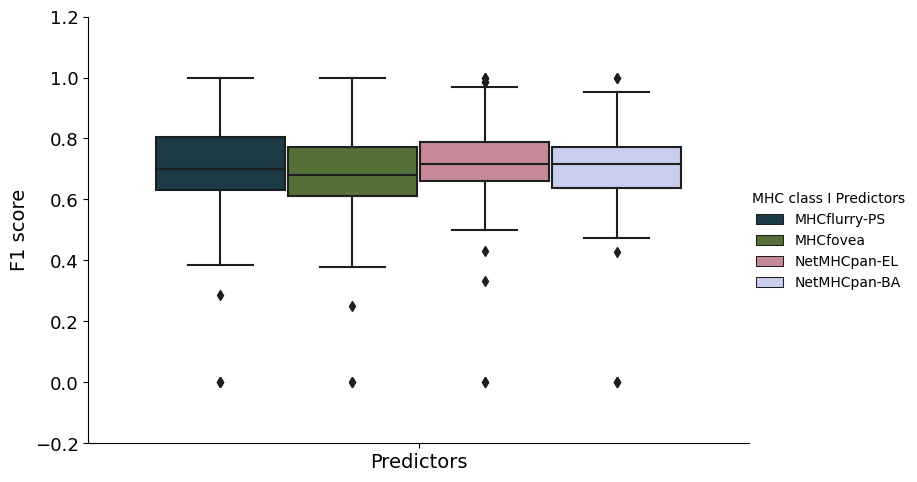

In [2]:
# F1 score based on %Rank or percentile
import math

with open('./data/benchmark/mhcflurry_bench_metrics_all_percentile.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_all_percentile.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_all_percentile.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    
    
x =  mhcflurry_bench_metrics['ROC_percentile'] + mhcfovea_bench_metrics['ROC'] + \
         netmhcpan_bench_metrics['ROC_EL']  + netmhcpan_bench_metrics['ROC_BA']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + \
    ['C - NetMHCpan-EL']*115 + ['D - NetMHCpan-BA']*115

roc_df = pd.DataFrame({'x' : x,
                       'predictor' : y})

x = mhcflurry_bench_metrics['PR_percentile'] +\
    mhcfovea_bench_metrics['PR'] + \
    netmhcpan_bench_metrics['PR_EL']  +\
    netmhcpan_bench_metrics['PR_BA']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + \
    ['C - NetMHCpan-EL']*115 + ['D - NetMHCpan-BA']*115


PR_df = pd.DataFrame({'x' : x,
                      'predictor' : y})


x = mhcflurry_bench_metrics['MCC_percentile'] +\
    mhcfovea_bench_metrics['MCC'] + \
    netmhcpan_bench_metrics['MCC_EL']  +\
    netmhcpan_bench_metrics['MCC_BA']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + \
    ['C - NetMHCpan-EL']*115 + ['D - NetMHCpan-BA']*115


MCC_df = pd.DataFrame({'x' : x,
                      'predictor' : y})

x = mhcflurry_bench_metrics['F1_score_percentile'] +\
    mhcfovea_bench_metrics['F1_score'] + \
    netmhcpan_bench_metrics['F1_score_EL']  +\
    netmhcpan_bench_metrics['F1_score_BA']
    
y = ['MHCflurry-PS']*115 + ['MHCfovea']*115 + \
    ['NetMHCpan-EL']*115 + ['NetMHCpan-BA']*115


F1_df = pd.DataFrame({'x' : x,
                      'predictor' : y})

x = mhcflurry_bench_metrics['pre_percentile'] +\
    mhcfovea_bench_metrics['pre'] + \
    netmhcpan_bench_metrics['pre_EL']  +\
    netmhcpan_bench_metrics['pre_BA']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + \
    ['C - NetMHCpan-EL']*115 + ['D - NetMHCpan-BA']*115


pre_df = pd.DataFrame({'x' : x,
                      'predictor' : y})

x = mhcflurry_bench_metrics['re_percentile'] +\
    mhcfovea_bench_metrics['re']+ \
    netmhcpan_bench_metrics['re_EL']  +\
    netmhcpan_bench_metrics['re_BA']
    
y = ['A - MHCflurry-PS']*115 + ['B - MHCfovea']*115 + \
    ['C - NetMHCpan-EL']*115 + ['D - NetMHCpan-BA']*115


re_df = pd.DataFrame({'x' : x,
                      'predictor' : y})

roc_df['y'] = ['ROC AUC']*len(roc_df)
PR_df['y'] = ['Precision-Recall AUC']*len(PR_df)
MCC_df['y'] = ['MCC']*len(MCC_df)
F1_df['y'] = ['F1 score']*len(F1_df)
pre_df['y'] = ['Precision']*len(pre_df)
re_df['y'] = ['Recall']*len(re_df)

df = pd.concat([F1_df])

b = sns.catplot(data=df, x='y', y='x',kind='box',hue="predictor", palette='cubehelix', height=5, aspect=1.5)

# plt.text(-0.35,1.05,'A', fontsize=13)
# plt.text(-0.22,1.05,'B', fontsize=13)
# plt.text(-0.09,1.05,'C', fontsize=13)
# plt.text(0.05,1.05,'D', fontsize=13)

# plt.text(1-0.35,1.05,'A', fontsize=13)
# plt.text(1-0.22,1.05,'B', fontsize=13)
# plt.text(1-0.09,1.05,'C', fontsize=13)
# plt.text(1+0.05,1.05,'D', fontsize=13)


# plt.text(3.5,8,'D - NetMHCpan-EL \nE - NetMHCpan-BA \nF - TransPHLA', fontsize=13)

b.set_xticklabels(['Predictors'],size=14,rotation=0)
b.set_ylabels('F1 score',size=14)
b.set_xlabels('')
b.legend.set_title('MHC class I Predictors')
b.set_yticklabels(size=13)


# Print F1 means

x = [mhcflurry_bench_metrics['F1_score_percentile'],
    mhcfovea_bench_metrics['F1_score'],
    netmhcpan_bench_metrics['F1_score_EL'],
    netmhcpan_bench_metrics['F1_score_BA']]

df = pd.DataFrame(x).T.rename(columns={0:'MHCflurry-PS', 
                                  1:'MHCfovea', 
                                  2:'NetMHCpan-EL', 
                                  3:'NetMHCpan-BA'})

print("ranking by F1: ",df.mean().sort_values(ascending=False).index.to_list())
print(df.mean())
print("Kruskal-Wallis: ", stats.kruskal(mhcflurry_bench_metrics['F1_score_percentile'],
    mhcfovea_bench_metrics['F1_score'],
    netmhcpan_bench_metrics['F1_score_EL'],
    netmhcpan_bench_metrics['F1_score_BA']))



# b.savefig('./SVGs/Review2_F1.svg',bbox_inches="tight")




In [51]:
import math

with open('./data/benchmark/mhcflurry_bench_metrics_all_percentile.pkl', 'rb') as handle:
    mhcflurry_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/mhcfovea_bench_metrics_all_percentile.pkl', 'rb') as handle:
    mhcfovea_bench_metrics = pickle.load(handle)
    
with open('./data/benchmark/netmhcpan_bench_metrics_all_percentile.pkl', 'rb') as handle:
    netmhcpan_bench_metrics = pickle.load(handle)
    

x = [mhcflurry_bench_metrics['F1_score_percentile']] +\
    [mhcfovea_bench_metrics['F1_score']] + \
    [netmhcpan_bench_metrics['F1_score_EL']]  +\
    [netmhcpan_bench_metrics['F1_score_BA']]
print(stats.kruskal(x[0], x[1], x[2], x[3]))

x = [mhcflurry_bench_metrics['pre_percentile']] +\
    [mhcfovea_bench_metrics['pre']] + \
    [netmhcpan_bench_metrics['pre_EL']] +\
    [netmhcpan_bench_metrics['pre_BA']]
print(stats.kruskal(x[0], x[1], x[2], x[3]))

x = [mhcflurry_bench_metrics['re_percentile']] +\
    [mhcfovea_bench_metrics['re']] + \
    [netmhcpan_bench_metrics['re_EL']]  +\
    [netmhcpan_bench_metrics['re_BA']]
print(stats.kruskal(x[0], x[1], x[2], x[3]))





KruskalResult(statistic=4.737455008871734, pvalue=0.19206283109542893)
KruskalResult(statistic=24.89864175316046, pvalue=1.621258309238433e-05)
KruskalResult(statistic=70.819095977536, pvalue=2.8500435557441477e-15)
